# Monte Carlo Prediction - Gridworld

* **Description:** Perform iterative policy evaluation for the gridworld example
* **Reference:** Reinforcement Learning, An Introduction, Second Edition by Sutton, Barto
* **Section:** Section 4.1, Example 4.1, Pg. 76 to 77

# Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

from tqdm import tqdm
from collections import defaultdict

# Define classes and functions

## Class: Agent

In [2]:
class Agent(object):
    '''
    Defines the agent class
    Arguments:
        policy_init: Initial policy to use for the agent class
        actions: List of actions that the agent can take
    '''
    
    def __init__(self, policy_init, actions):
        self.policy = policy_init # Initial policy
        self.actions = actions # List of actions
        
    def step(self, state):
        # Execute one step of agent based on current state
        if isinstance(self.policy, str):
            if(self.policy == 'random'): # Choose an action randomly for 'random' policy
                return np.random.choice(self.actions)        
        

## Class: Environment - Grid World

In [3]:
class GW_Environment(object):
    '''
    Defines the environment class for a n x n gridworld problem
    Arguments:
        n: Defines the size of the gridworld. n x n gridworld is generated
        reward: Reward value for each transition
    '''
    
    def __init__(self, n, reward):
        self.n = n
        self.state_list = list(range(n ** 2))
        self.reward = reward
        
    def set_state(self, state): # Set the environment to a particular state
        self.state = state
        
    def respond(self, action): # Respond to a particular action
        if (self.state == 0 or self.state == (self.n ** 2 - 1)): 
            # Terminal states. Stay in that state for any action and return reward = 0
            return self.state, 0
        else:
            if (action == 'up'): # Execute up action
                if (self.state < self.n):
                    self.state = self.state
                else:
                    self.state = self.state - 4
            if (action == 'down'): # Execute down action
                if (self.state >= (self.n * (self.n - 1))):
                    self.state = self.state
                else:
                    self.state = self.state + 4
            if (action == 'right'): # Execute right action
                if ((self.state + 1) % self.n == 0):
                    self.state = self.state
                else:
                    self.state = self.state + 1
            if (action == 'left'): # Execute left action
                if (self.state % self.n == 0):
                    self.state = self.state
                else:
                    self.state = self.state - 1
            return self.state, self.reward    

## Function: iter_pol_eval

In [4]:
def iter_pol_eval(svf_init, actions_list, gw_envir, theta, plot_iter_ind, num_cols, plot = False):
    '''
    Run the iterative policy evaluation algorithm - Non in-place method
    Arguments:
        svf_init: Initial state-value function
        actions_list: List of actions that agent can take.
        gw_envir: Environment instance
        theta: Accuracy threshold at which to stop iteration (Pg. 97 of RL_Sutton) 
        plot_iter_ind: Iteration indices at which value functions will be plotted
        num_cols: Number of columns to use for plotting
        plot: boolean. If True, plot value functions
    '''

    num_plots = len(plot_iter_ind) + 2 # Plot initial and final value functions also
    num_rows = math.ceil(num_plots / num_cols) # Number of rows to use for plotting
    fig = plt.figure(figsize = ((num_cols * 3), (num_rows * 3.2)))
    fig.suptitle('State Value Functions at different iterations', fontsize = 30)
    sns.set(font_scale = 1.15)
    
    ind = 1 # Initialize iteration index 
    gw_size = int(np.sqrt(len(svf_init)))
    plot_ind = 1
    while(1): # Run iterative policy evaluation till convergence
        if (ind == 1):
            svf_curr = svf_init # Initialize current state value function in first iteration
        else:
            svf_curr = svf_next
        svf_next = np.zeros(len(svf_init)) # v_(k+1): Placeholder for next state value function.        
        # Loop through all states (leave out terminal states)
        for s in range(1, (len(svf_init) - 1)): 
            for act in actions_list: # Execute all actions for each state
                gw_envir.set_state(s)
                s_pr, r = gw_envir.respond(act) # Get next state and reward from environment
                # Note: Only one possible next state, reward for each s,a pair
                # So, p(s',r|s,a) = 1
                svf_next[s] += r + svf_curr[s_pr] # Update next state value function
            # For equiprobable random policy pi(a|s) = 1/(num_actions)
            svf_next[s] = svf_next[s] / len(actions_list)
        
        # Plot value function
        if (plot):
            if (ind == 1):
                ax = plt.subplot(num_rows, num_cols, (plot_ind))
                ax.set_title(f"Initial_Value_Function", fontsize = 15)
                svf_table_df = pd.DataFrame(svf_curr.reshape(gw_size, gw_size))
                sns.heatmap(svf_table_df, annot = True, cbar = False, square = True,\
                            cmap = 'Greys', vmin = 0, fmt = "0.1f", linewidths = 1,\
                            linecolor = 'black', xticklabels = False, yticklabels = False, ax = ax)
                plot_ind += 1
            if (ind in plot_iter_ind):
                ax = plt.subplot(num_rows, num_cols, (plot_ind))
                ax.set_title(f"Iteration: {ind}", fontsize = 15)
                svf_table_df = pd.DataFrame(svf_next.reshape(gw_size, gw_size))
                sns.heatmap(svf_table_df, annot = True, cbar = False, square = True,\
                            cmap = 'Greys', vmin = 0, fmt = "0.1f", linewidths = 1,\
                            linecolor = 'black', xticklabels = False, yticklabels = False, ax = ax) 
                plot_ind += 1
            
        # Compute delta
        svf_delta = svf_next - svf_curr
        delta = np.dot(svf_delta, svf_delta.T)
        if (delta < theta):
            break
        ind += 1
    
    if (plot):
        ax = plt.subplot(num_rows, num_cols, (plot_ind))
        ax.set_title(f"Final_Value_Function", fontsize = 15)
        svf_table_df = pd.DataFrame(svf_next.reshape(gw_size, gw_size))
        sns.heatmap(svf_table_df, annot = True, cbar = False, square = True,\
                    cmap = 'Greys', vmin = 0, fmt = "0.1f", linewidths = 1,\
                    linecolor = 'black', xticklabels = False, yticklabels = False, ax = ax) 
        
    return ind, svf_next

## Function: gen_episode

In [5]:
def gen_episode(envir, agent, init_state, term_states, verb = False):
    
    '''
    Generate one episode of agent-environment interaction
    Arguments:
        envir: Instance of environment to use for generating episode
        agent: Instance of agent to use for generating episode
        init_state: Initial state from which episode will start
        term_states: List of states that are considered terminal states
        verb: Boolean, controls verbosity
        
    Returns:
        states_list: List of states encountered in the episode (includes init_state and term_state)
        actions_list: List of actions take by agent at each time step
        rewards_list: List of rewards received by agent at each time step
    '''
    
    states_list = [] # Placeholder to store list of all states encountered in episode
    actions_list = [] # Placeholder to store list of all actions taken by agent
    rewards_list = [] # Placeholder to store list of rewards received at each step
        
    envir.set_state(init_state) # Initialize environment state
    states_list.append(envir.state) # Update states_list with initial state
    while(1): # Run agent till terminal states are reached
        s_t = envir.state # Retrieve current state of environment (State at time t)
        a_t = agent.step(s_t) # Action taken by agent at time t
        s_tplus1, rew_tplus1 = envir.respond(a_t) # Environment reponds to action a_t and moves
                                                  # to state s_tplus1 and
                                                  # returns a reward rew_tplus1
        states_list.append(s_tplus1) # Update states_list
        actions_list.append(a_t) # Update actions_list
        rewards_list.append(rew_tplus1) # Update rewards list
        
        # Stop episode if terminal state has been reached
        if (s_tplus1 in term_states): 
            if (verb):
                print("Terminal state reached.")
            break
            
    return states_list, actions_list, rewards_list        

## Function: mc_prediction

In [6]:
def mc_prediction(envir, agent, non_term_states, term_states, num_ep, gamma, visit_type):
    
    '''
    Function to run MC prediction and estimate state value function
    Arguments:
        envir: Instance of environment to use for generating episode
        agent: Instance of agent to use for generating episode
        non_term_states: List of non-terminal states
        term_states: List of terminal states
        num_ep: Number of episodes to use for MC prediction algorithm
        gamma: Discounting factor for reward computation
        visit_type: 'first' for first-visit MC prediction,
                    'every' for every-visit MC prediction.
        
    Returns:
        svpi: State value function for policy with which agent has been initialized
        state_count: Number of times each state is encountered during MC prediction
    '''
    
    # Initialize value function and count for all states to zero
    svpi = defaultdict(int) # State value function for given policy 'pi'
    avpi = defaultdict(int) # Action value function for given policy 'pi'
    state_count = defaultdict(int) # Number of times each state is encountered across episodes
    st_act_count = defaultdict(int) # Number of times a particular state-action pair is encountered across episodes.
    for state in non_term_states:
        svpi[state] = 0
        state_count[state] = 0
    
    # Loop through 'num_ep' episodes
    for ep in tqdm(range(num_ep)):
        init_state = np.random.choice(non_term_states) # Choose a random initial state
        ep_states, ep_actions, ep_rewards = gen_episode(envir, agent, init_state, term_states) # Generate one episode
        num_timesteps = len(ep_rewards) # Number of timesteps in current episode
        G = 0 # Initialize return to 0
        
        # Loop through each timestep of current episode
        for ind in range((num_timesteps - 1), -1, -1): 
            G = gamma * G + ep_rewards[ind] # Update return of current timestep
            curr_state = ep_states[ind] # Retrieve state of current timestep
            curr_action = ep_actions[ind] # Retrieve action of current timestep
            curr_st_act = str(curr_state) + '_' + curr_action
            if (visit_type == 'first'): # For first-visit MC prediction
                if (curr_state not in ep_states[0:ind]):
                    state_count[curr_state] += 1
                    svpi[curr_state] += (G - svpi[curr_state]) / state_count[curr_state]
            elif (visit_type == 'every'): # For every-visit MC prediction
                state_count[curr_state] += 1
                st_act_count[curr_st_act] += 1
                svpi[curr_state] += (G - svpi[curr_state]) / state_count[curr_state]
                avpi[curr_st_act] += (G - avpi[curr_st_act]) / st_act_count[curr_st_act]
                
        
    return svpi, state_count, avpi, st_act_count

# Initialize RL system

In [7]:
policy_init = 'random' # Set initial policy to equiprobable random policy
actions_list = ['up', 'down', 'right', 'left']
gw_size = 4 # 4 x 4 gridworld

gw_agent = Agent(policy_init, actions_list) # Instantiate agent
gw_envir = GW_Environment(gw_size, -1) # Instantiate environment

# Run Iterative Policy Evaluation

Policy evaluation converged in 131 steps


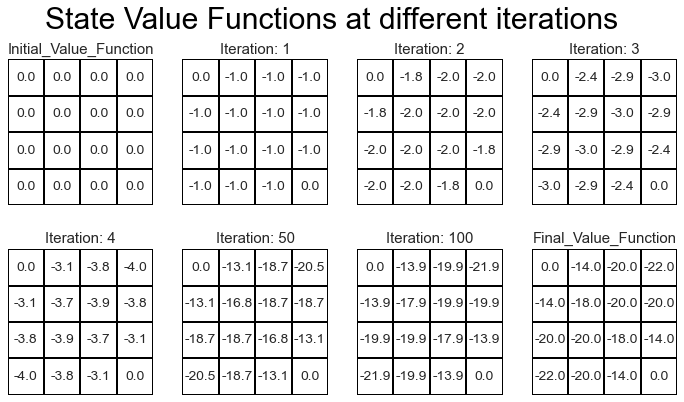

In [8]:
svf_init = np.zeros(gw_size ** 2) # v_0: Initialize value function array to all zeros.
theta = 1e-5 # Accuracy threshold at which to stop iteration
num_cols = 4
plot_iter_ind = [1, 2, 3, 4, 50, 100]

# Run iterative policy evaluation
ind, svf_final = iter_pol_eval(svf_init, actions_list, gw_envir, theta, plot_iter_ind,\
                               num_cols, True)
print(f"Policy evaluation converged in {ind} steps")    

# Run Monte-Carlo Prediction

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:11<00:00, 2527.40it/s]


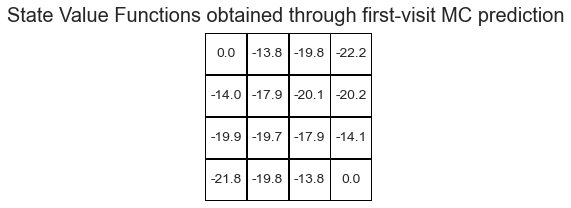

In [9]:
# Initialize required variables
term_states = [0, 15] # List of terminal states
non_term_states = list(range(1, 15, 1)) # List of non-terminal states
gamma = 1 # Discount factor for return calculation
num_ep = 30000 # Number of episodes to run
visit_type = 'every'

# Run first-visit MC Prediction algorithm
svpi, state_count, avpi, st_act_count = mc_prediction(gw_envir, gw_agent, non_term_states, term_states, num_ep,\
                                                      gamma, visit_type)

# Extract state-value function corresponding to policy pi
svf_pi = [0] # First terminal state
for key in svpi.keys(): # Non-terminal states
    svf_pi.append(svpi[key])
svf_pi.append(0) # Last terminal state
svf_pi = np.array(svf_pi)

fig = plt.figure(figsize = (3, 3.2))
fig.suptitle('State Value Functions obtained through first-visit MC prediction', fontsize = 20)
sns.set(font_scale = 1.15)
ax = plt.subplot(1, 1, 1)
svf_table_df = pd.DataFrame(svf_pi.reshape(gw_size, gw_size))
sns.heatmap(svf_table_df, annot = True, cbar = False, square = True,\
            cmap = 'Greys', vmin = 0, fmt = "0.1f", linewidths = 1,\
            linecolor = 'black', xticklabels = False, yticklabels = False, ax = ax);

In [61]:
(avpi['2_left'] + avpi['2_right'] + avpi['2_up'] + avpi['2_down'])/4

-19.757964684176404

# Run TD(0) Prediction

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:41<00:00, 2407.17it/s]


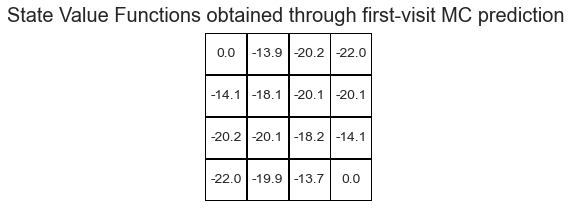

In [44]:
#gw_agent()
# Initialize required variables
term_states = [0, 15] # List of terminal states
non_term_states = list(range(1, 15, 1)) # List of non-terminal states
alpha = 0.001 # Algorithm parameter
gamma = 1 # Discount factor for return calculation
svf = np.zeros(gw_size ** 2) # v_0: Initialize value function array to all zeros.
num_ep = 100000 # Number of episodes to run
verb = False

envir = gw_envir
agent = gw_agent

# Loop through 'num_ep' episodes
for ep in tqdm(range(num_ep)):
    init_state = np.random.choice(non_term_states) # Choose a random initial state
       
    states_list = [] # Placeholder to store list of all states encountered in episode
    actions_list = [] # Placeholder to store list of all actions taken by agent
    rewards_list = [] # Placeholder to store list of rewards received at each step    

    envir.set_state(init_state) # Initialize environment state    
    states_list.append(envir.state) # Update states_list with initial state
    
    while(1): # Run agent till terminal states are reached
        s_t = envir.state # Retrieve current state of environment (State at time t)
        a_t = agent.step(s_t) # Action taken by agent at time t
        s_tplus1, rew_tplus1 = envir.respond(a_t) # Environment reponds to action a_t and moves
                                                  # to state s_tplus1 and
                                                  # returns a reward rew_tplus1
        svf[s_t] = svf[s_t] + alpha * (rew_tplus1 + gamma * svf[s_tplus1] - svf[s_t])
        states_list.append(s_tplus1) # Update states_list
        actions_list.append(a_t) # Update actions_list
        rewards_list.append(rew_tplus1) # Update rewards list
        
        # Stop episode if terminal state has been reached
        if (s_tplus1 in term_states): 
            if (verb):
                print("Terminal state reached.")
            break    

svf_pi = np.array(svf)
fig = plt.figure(figsize = (3, 3.2))
fig.suptitle('State Value Functions obtained through first-visit MC prediction', fontsize = 20)
sns.set(font_scale = 1.15)
ax = plt.subplot(1, 1, 1)
svf_table_df = pd.DataFrame(svf_pi.reshape(gw_size, gw_size))
sns.heatmap(svf_table_df, annot = True, cbar = False, square = True,\
            cmap = 'Greys', vmin = 0, fmt = "0.1f", linewidths = 1,\
            linecolor = 'black', xticklabels = False, yticklabels = False, ax = ax);